In [6]:
import torch
import cv2
import random
from models import BaseEvaluator
from datasets import VQAInferenceDataset, get_fragments

from matplotlib import pyplot as plt

from scipy.stats import spearmanr, pearsonr
from scipy.stats.stats import kendalltau as kendallr
import numpy as np

from time import time
from tqdm import tqdm

## choose the device you would like to run on

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [2]:
## defining model and loading checkpoint

model = BaseEvaluator().to(device)
load_path = 'pretrained_weights/all_aligned_fragments.pth'
state_dict = torch.load(load_path, map_location='cpu')

if 'state_dict' in state_dict:
    state_dict = state_dict['state_dict']
    from collections import OrderedDict
    i_state_dict = OrderedDict()
    for key in state_dict.keys():
        if 'cls' in key:
            tkey = key.replace('cls', 'vqa')
            i_state_dict[tkey] = state_dict[key]
        else:
            i_state_dict[key] = state_dict[key]

model.load_state_dict(i_state_dict)

<All keys matched successfully>

In [3]:
## getting datasets (if you want to load from existing VQA datasets)

dataset_name = 'LIVE_VQC'
dataset_path = f'/mnt/lustre/hnwu/datasets/{dataset_name}'

inference_set = VQAInferenceDataset(f'{dataset_path}/labels.txt', dataset_path)


In [96]:
## run the model with examplar fragment video
## with ultra...fast performance

## for example from the dataset

q = random.randrange(len(inference_set))
data = inference_set[q]
vfrag = data['video'].to(device)

## or, directly get from your input videos as follows
## where 'video' is a torch Tensor

## from datasets import temporal_sampling (not implemented yet)

# data = temporal_sampling(video, 32, 2, 4)

# vfrag = get_fragments(data['video']).to(device)

st = time()
demo_result = model(vfrag)
print(demo_result.shape)
demo_result = demo_result.reshape((-1,) + demo_result.shape[-2:])
score = torch.mean(demo_result)
end = time()

print(f'The quality of the video is {score.item():.4f}, consuming time {end-st:.4f}s.')

## see the spatial-temporal quality localization for a reference
def init_demo_reader(path, i):
    from decord import VideoReader, cpu
    video_names = [ele.split(',')[0] for ele in open(f'{path}/labels.txt').readlines()]
    frame_reader = VideoReader(f'{path}/{video_names[i]}', ctx=cpu(0))
    return frame_reader

frame_reader = init_demo_reader(dataset_path, q)

torch.Size([4, 1, 16, 7, 7])
The quality of the video is -0.0435, consuming time 0.0743s.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


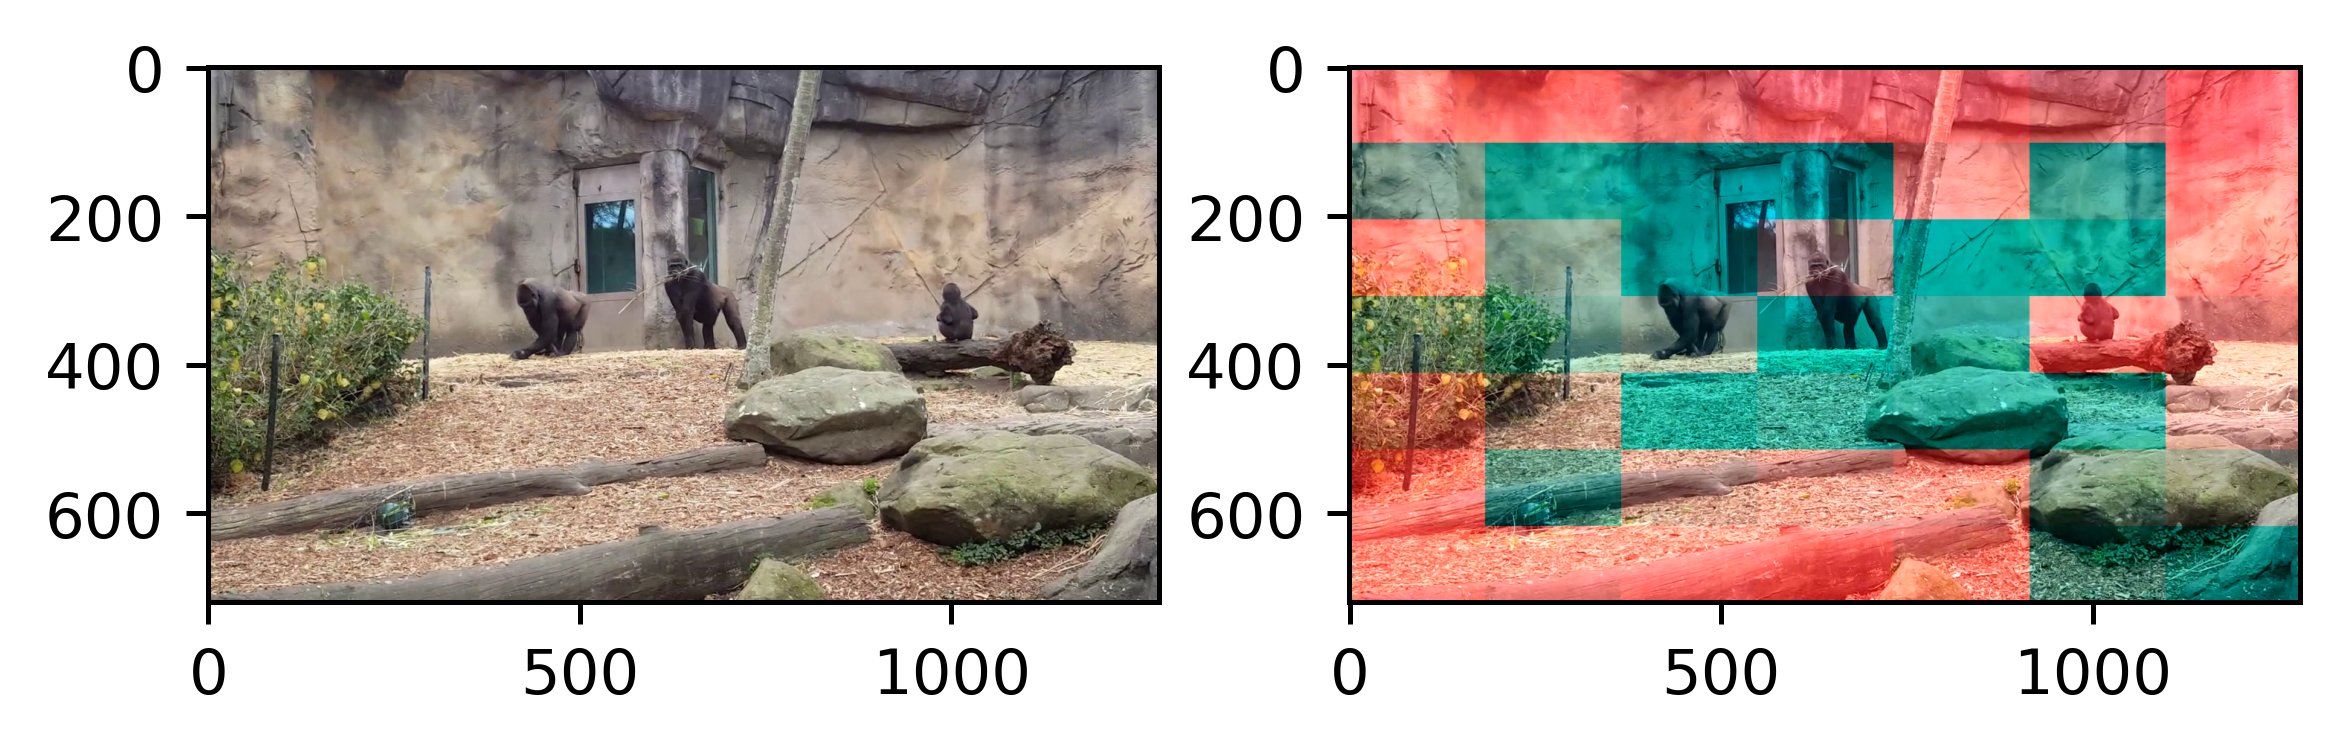

In [97]:
video_names = [ele.split(',')[0] for ele in open(f'{dataset_path}/labels.txt').readlines()]

r_index = random.randrange(len(data['frame_inds']))
frame_index = data['frame_inds'][r_index]
frame = frame_reader[frame_index]
frame_quality_map = demo_result[r_index // 2]

def rescale(pr, gt=None):
    if gt is None:
        pr = ((pr - np.mean(pr)) / np.std(pr))
    else:
        pr = ((pr - np.mean(pr)) / np.std(pr)) * np.std(gt) + np.mean(gt)
    return pr

frame_quality_map = rescale(frame_quality_map.cpu().numpy())
qlt = cv2.resize(frame_quality_map, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
plt.figure(dpi=450)
plt.subplot(221)
plt.imshow(frame)
plt.subplot(222)
plt.imshow(frame / 255. - np.stack((qlt,) + (np.zeros_like(qlt),)*2, -1) / 2.)
plt.savefig(f'demos/demo_{video_names[q].split("/")[-1]}.png')

In [ ]:
## run inference for a whole testing database
inference_loader = torch.utils.data.DataLoader(inference_set, batch_size=1, num_workers=4)
results = []

for i, data in tqdm(enumerate(inference_loader)):
    result = dict()
    vfrag = data['video'].to(device).squeeze(0)
    with torch.no_grad():
        result['pr_labels'] = model(vfrag).cpu().numpy()
    result['gt_label'] = data['gt_label'].item()
    result['frame_inds'] = data['frame_inds']
    del data
    results.append(result)
    


In [95]:
## calculating several accuracies indices
gt_labels = [r['gt_label'] for r in results]
pr_labels = [np.mean(r['pr_labels'][:]) for r in results]
pr_labels = rescale(pr_labels, gt_labels)

srocc = spearmanr(gt_labels, pr_labels)[0]
plcc = pearsonr(gt_labels, pr_labels)[0]
krocc = kendallr(gt_labels, pr_labels)[0]
rmse = np.sqrt(((gt_labels - pr_labels) ** 2).mean())

print(f'For the sub-dataset we inference, the accuracy of the model is as follows:\n  SROCC: {srocc:.4f}\n  PLCC:  {plcc:.4f}\n  KROCC: {krocc:.4f}\n  RMSE:  {rmse:.4f}')

NameError: name 'results' is not defined